In [1]:
%reset -f

In [2]:
import matplotlib.pyplot as plt
# %matplotlib qt
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import time
import random
def print_np(x):
    print ("Type is %s" % (type(x)))
    print ("Shape is %s" % (x.shape,))
import seaborn as sns
import matplotlib.font_manager as font_manager
import scipy
# sns.set_style("whitegrid")
csfont = {'fontsize':15,'fontname':'Times New Roman'}
# plt.title('title',**csfont)
font = font_manager.FontProperties(family='Times New Roman',
#                                    weight='bold',
                                   style='normal', size=15)

In [3]:
import os
import sys
sys.path.append('../')

In [4]:
from model import FreeFlyer
from constraints import FreeFlyerConstraints
from cost import FreeFlyerCost
from scipy.integrate import solve_ivp
from matplotlib.patches import Ellipse
from utils.utils_alg import get_neighbor_vec,get_K_discrete
# from utils.utils_plot import plot_traj,plot_traj_set,plot_state_input
from utils.utils_plot import plot_ellipse_2D,plot_ellipse_3D,data_for_cylinder_along_z

# from trajopt_tmp import trajopt
from trajopt import trajopt
from funlopt import funlopt
from Lipschitz import Lipschitz
from Scaling import TrajectoryScaling

from utils.utils_alg import get_sample_eta_w,propagate_model
import cvxpy as cvx
from scipy.integrate import solve_ivp
from utils.utils_alg import forward_full_with_K,get_sample_trajectory



(CVXPY) Nov 07 04:25:44 PM: Encountered unexpected exception importing solver SCS:
ImportError("dlopen(/opt/anaconda3/envs/py309/lib/python3.9/site-packages/_scs_direct.cpython-39-darwin.so, 0x0002): Library not loaded: @rpath/liblapack.3.dylib\n  Referenced from: <F9700F1C-290B-3DF3-8D09-CFDF44BAE051> /opt/anaconda3/envs/py309/lib/python3.9/site-packages/_scs_direct.cpython-39-darwin.so\n  Reason: tried: '/opt/anaconda3/envs/py309/lib/python3.9/site-packages/../../liblapack.3.dylib' (no such file), '/opt/anaconda3/envs/py309/lib/python3.9/site-packages/../../liblapack.3.dylib' (no such file), '/opt/anaconda3/envs/py309/bin/../lib/liblapack.3.dylib' (no such file), '/opt/anaconda3/envs/py309/bin/../lib/liblapack.3.dylib' (no such file), '/usr/local/lib/liblapack.3.dylib' (no such file), '/usr/lib/liblapack.3.dylib' (no such file, not in dyld cache)")


In [5]:
N = 15
tf = 200
delT = tf/N

## obstacle setting

In [6]:
def get_H_obs(rx,ry) :
    return np.diag([1/rx,1/ry])
# obstacle
c_list = []
H_list = []
c1 = [0.5,1.2]
H1 = get_H_obs(0.8,0.8)
c_list.append(c1)
H_list.append(H1)
c2 = [2.5,2.0]
H2 = get_H_obs(0.8,0.8)
c_list.append(c2)
H_list.append(H2)
idx = 0
Xo1,Yo1,Zo1 = data_for_cylinder_along_z(c_list[idx][0],c_list[idx][1],1/H_list[idx][0,0],1/H_list[idx][1,1],3)
idx = 1
Xo2,Yo2,Zo2 = data_for_cylinder_along_z(c_list[idx][0],c_list[idx][1],1/H_list[idx][0,0],1/H_list[idx][1,1],3)

## initial and final conditions 

In [7]:
myModel = FreeFlyer.freeflyer('freeflyer','numeric_central')
ix = myModel.ix
iu = myModel.iu
iw = myModel.iw
iq = myModel.iq
ip = myModel.ip

C = myModel.C
D = myModel.D
E = myModel.E
G = myModel.G

myCost = FreeFlyerCost.freeflyer('Hello',ix,iu,N)
myConst = FreeFlyerConstraints.freeflyer('Hello',ix,iu)
myConst.set_obstacle(c_list,H_list)


In [8]:
# xi = np.array([0,j,5, 0.035,0.035,0, 0,0,0, 0,0,0])
xi = np.array([0,0,3, 0,0,0, -np.deg2rad(30),np.deg2rad(25),np.deg2rad(5), 0,0,0])
xf = np.array([3,3,0, 0,0,0, 0,0,0, 0,0,0])

In [9]:
Qini = np.diag([0.2**2,0.2**2,0.2**2, \
                0.02**2,0.02**2,0.02**2, \
                np.deg2rad(5)**2,np.deg2rad(5)**2,np.deg2rad(5)**2, \
                np.deg2rad(0.1)**2,np.deg2rad(0.1)**2,np.deg2rad(0.1)**2])
Qf = Qini

x0 = np.zeros((N+1,ix))
for i in range(N+1) :
    x0[i] = (N-i)/N * xi + i/N * xf
# u0 = np.zeros((N+1,iu))
x0[:,3] = 1e-6
x0[:,4] = 1e-6
x0[:,5] = 1e-6
x0[:,9] = 1e-6
x0[:,10] = 1e-6
x0[:,11] = 1e-6
u0 = 1e-12*np.ones((N+1,iu))

In [10]:
A,B,s,z,x_prop_n = myModel.diff_discrete_zoh(x0[0:N,:],u0[0:N,:],delT,tf) 
S = np.eye(ix)
R = np.eye(iu)
K0 = get_K_discrete(A,B,S,1e3*R,S,N,ix,iu)
Q0 = np.tile(Qini,(N+1,1,1))
Y0 = K0@Q0[:N]
betahat = np.ones(N+1)

In [11]:
x_max = np.array([5,5,5,1,1,1,np.pi,np.pi,np.pi,np.deg2rad(1),np.deg2rad(1),np.deg2rad(1)])
x_min = np.zeros(ix)

u_max = np.array([0.02,0.02,0.02,100*1e-6,100*1e-6,100*1e-6]) 
u_min = np.zeros(iu)

traj_scaling = TrajectoryScaling(x_min,x_max,u_min,u_max,tf)

x_max = [0.1,0.1,0.1, 0.01,0.01,0.01, np.deg2rad(1),np.deg2rad(1),np.deg2rad(1), np.deg2rad(1),np.deg2rad(1),np.deg2rad(1)]
# x_max = np.sqrt(np.diag(Qini))
x_min = np.zeros(ix)

# umax = umax
u_min = np.zeros(iu)

funl_scaling = TrajectoryScaling(x_min,x_max,u_min,u_max,tf)
funl_scaling.snu_p = 1e5

In [12]:
max_iter = 20
traj_solver= trajopt('freeflyer',N,tf,max_iter,myModel,myCost,myConst,Scaling=traj_scaling,
              w_c=1e3,w_vc=1e2,w_tr=1e0,tol_vc=1e-6,tol_tr=1e-4,tol_dyn=1e-3,
              ignore_dpp=True,
              verbosity=True)

Is DPP?  True


In [13]:
xfwd,_,xnom,unom,_,total_num_iter,_,_,_,_,history_nom = traj_solver.run(x0,u0,xi,xf)
tnom = np.array(range(N+1))*delT

┌──────────────────────────────────────────────────────────────────────────────────────────────┐

│                                              ..:: SCP ::..                                   │

├──────┬───────────┬──────────┬─────────┬───────────┬────────────┬─────────┬─────────┬─────────┤

│ iter │  total    │ final    │ input   │     -     │ total cost │ vc      │ tr      │ dyn     │

│      │  cost     │ time [s] │ energy  │     -     │ reduction  │ (log10) │         │         │

├──────┼───────────┼──────────┼─────────┼───────────┼────────────┼─────────┼─────────┼─────────┤

│1     │2.093      │200.000   │0.000353 │0          │-2.09       │1(-11.36)│0(1.740 )│0(0.002 )│
│2     │0.320      │200.000   │0.000307 │0          │1.77        │1(-11.91)│0(0.013 )│1(0.000 )│
│3     │0.298      │200.000   │0.000296 │0          │0.0211      │1(-12.41)│0(0.002 )│1(0.000 )│
│4     │0.294      │200.000   │0.000293 │0          │0.00414     │1(-13.11)│0(0.001 )│1(0.000 )│
│5     │0.292      │200.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


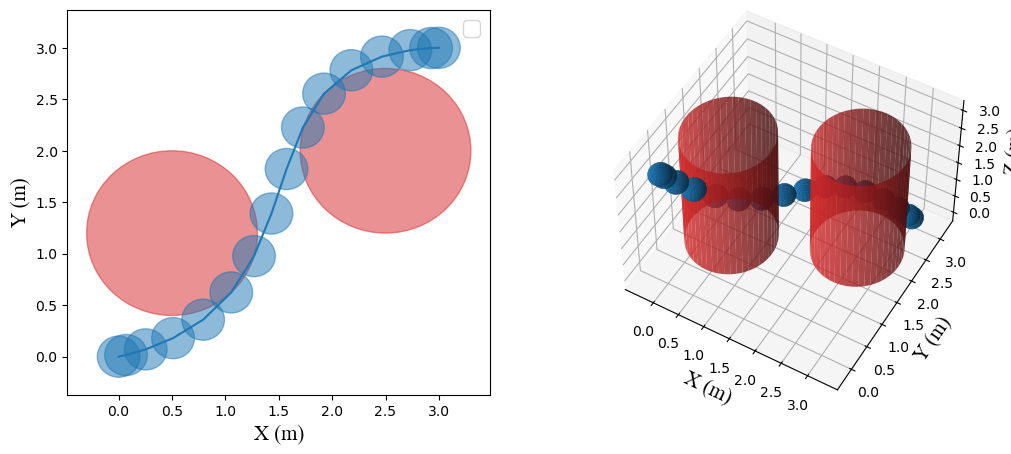

In [14]:
fig = plt.figure(1,figsize=(12,5))
ax = fig.add_subplot(121)
for ce,H in zip(c_list,H_list) :
        rx = 1/H[0,0]
        ry = 1/H[1,1]
        circle1 = Ellipse((ce[0],ce[1]),rx*2,ry*2,color='tab:red',alpha=0.5,fill=True)
        ax.add_patch(circle1)
for i in range(N+1) :
        plot_ellipse_2D(ax,Q0[i],xnom[i])
ax.set_xlabel('X (m)',**csfont)
ax.set_ylabel('Y (m)',**csfont)
ax.plot(xnom[:,0],xnom[:,1],color='tab:blue')
plt.legend(fontsize=15)
plt.subplot

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(Xo1, Yo1, Zo1, alpha=0.8,color='tab:red')
ax.plot_surface(Xo2, Yo2, Zo2, alpha=0.8,color='tab:red')
ax.set_xlabel('X (m)',**csfont)
ax.set_ylabel('Y (m)',**csfont)
ax.set_zlabel('Z (m)',**csfont)
ax.plot(xnom[:, 0],xnom[:, 1], xnom[:, 2],'o-',color='tab:blue')
for i in range(N+1) :
        plot_ellipse_3D(ax,Q0[i],xnom[i])
    
ax.view_init(50, -60)
# plt.gca().set_aspect('equal', adjustable='box')

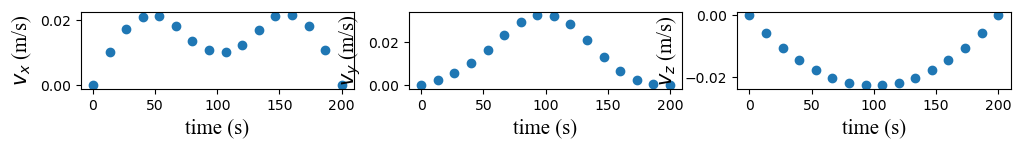

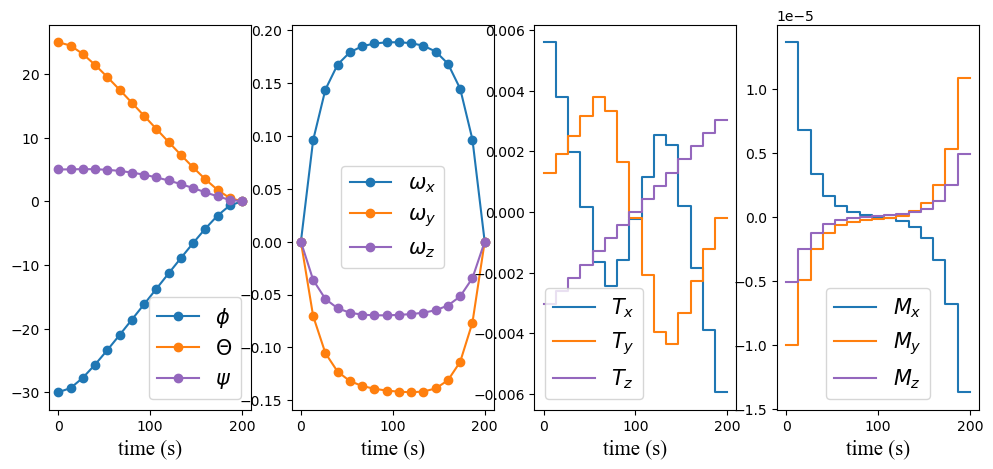

In [15]:
fig = plt.figure(1,figsize=(12,1))
ax = fig.add_subplot(131)
ax.set_xlabel('time (s)',**csfont)
ax.set_ylabel('$v_x$ (m/s)',**csfont)
ax.plot(tnom,xnom[:,3],'o',color='tab:blue')
ax = fig.add_subplot(132)
ax.set_xlabel('time (s)',**csfont)
ax.set_ylabel('$v_y$ (m/s)',**csfont)
ax.plot(tnom,xnom[:,4],'o',color='tab:blue')
ax = fig.add_subplot(133)
ax.set_xlabel('time (s)',**csfont)
ax.set_ylabel('$v_z$ (m/s)',**csfont)
ax.plot(tnom,xnom[:,5],'o',color='tab:blue')
fig = plt.figure(2,figsize=(12,5))
ax = fig.add_subplot(141)
ax.set_xlabel('time (s)',**csfont)
ax.plot(tnom,np.rad2deg(xnom[:,6]),'o-',color='tab:blue',label='$\phi$')
ax.plot(tnom,np.rad2deg(xnom[:,7]),'o-',color='tab:orange',label='$\Theta$')
ax.plot(tnom,np.rad2deg(xnom[:,8]),'o-',color='tab:purple',label='$\psi$')
ax.legend(prop=font)
ax = fig.add_subplot(142)
ax.set_xlabel('time (s)',**csfont)
ax.plot(tnom,np.rad2deg(xnom[:,9]),'o-',color='tab:blue',label='$\omega_x$')
ax.plot(tnom,np.rad2deg(xnom[:,10]),'o-',color='tab:orange',label='$\omega_y$')
ax.plot(tnom,np.rad2deg(xnom[:,11]),'o-',color='tab:purple',label='$\omega_z$')
ax.legend(prop=font)
ax = fig.add_subplot(143)
ax.set_xlabel('time (s)',**csfont)
ax.step(tnom, [*unom[:N,0],unom[N-1,0]],'-',
        color='tab:blue',where='post',label='$T_x$')
ax.step(tnom, [*unom[:N,1],unom[N-1,1]],'-',
        color='tab:orange',where='post',label='$T_y$')
ax.step(tnom, [*unom[:N,2],unom[N-1,2]],'-',
        color='tab:purple',where='post',label='$T_z$')
ax.legend(prop=font)
ax = fig.add_subplot(144)
ax.set_xlabel('time (s)',**csfont)
ax.step(tnom, [*unom[:N,3],unom[N-1,3]],'-',
        color='tab:blue',where='post',label='$M_x$')
ax.step(tnom, [*unom[:N,4],unom[N-1,4]],'-',
        color='tab:orange',where='post',label='$M_y$')
ax.step(tnom, [*unom[:N,5],unom[N-1,5]],'-',
        color='tab:purple',where='post',label='$M_z$')
ax.legend(prop=font)
# fig = plt.figure(3,figsize=(6,5))

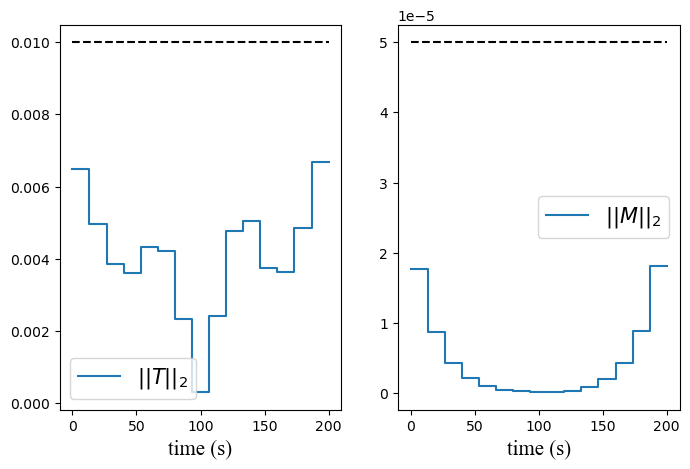

In [16]:
Tnorm = np.linalg.norm(unom[:,0:3],axis=1)
Mnorm = np.linalg.norm(unom[:,3:],axis=1)
fig = plt.figure(3,figsize=(8,5))
ax = fig.add_subplot(121)
ax.set_xlabel('time (s)',**csfont)
ax.plot(tnom, tnom*0 + myConst.Tmax,'--',color='black')
ax.step(tnom, [*Tnorm[:N],Tnorm[N-1]],'-',
        color='tab:blue',where='post',label='$||T||_2$')
ax.legend(prop=font)
ax = fig.add_subplot(122)
ax.set_xlabel('time (s)',**csfont)
ax.plot(tnom, tnom*0 + myConst.Mmax,'--',color='black')
ax.step(tnom, [*Mnorm[:N],Mnorm[N-1]],'-',
        color='tab:blue',where='post',label='$||M||_2$')
ax.legend(prop=font)

# Initial guess for funnel

In [17]:
alpha = 0.99
lambda_mu = 0.1
funl_w_tr = 0
w_Q = 1
w_K = 5*1e2


funl_solver = funlopt('freeflyer',ix,iu,iq,ip,iw,N,funl_scaling,
                      alpha=alpha,
                      lambda_mu=lambda_mu,
                      w_Q = w_Q,
                      w_K = w_K,
                      w_tr=funl_w_tr,
                      ignore_dpp=True,
                      solver="MOSEK",
                      flag_nonlinearity=True)
                      
funl_solver.cvx_initialize(Qini,Qf)
lip_estimator = Lipschitz('freeflyer',ix,iu,iq,ip,iw,N,num_sample=256,
                            flag_uniform=True)

nonlinear funnel
Is DPP?  True


In [18]:
A,B,F,s,z,_ = myModel.diff_discrete_zoh_noise(xnom,unom,np.zeros((N,iw)),delT,tf) 
Ktmp = get_K_discrete(A,B,S,R,S,N,ix,iu)
Qtmp = np.tile(Qini,(N+1,1,1))
Ytmp = Ktmp@Qtmp[:N]

In [19]:
lip_estimator.initialize(xnom,unom,xfwd,Qtmp,Ktmp,A,B,C,D,E,F,G,myModel)
gammanew = lip_estimator.update_lipschitz_norm(myModel,delT)
print(gammanew)
# gammanew = lip_estimator.update_lipschitz_parallel(myModel,delT)

[0.20636664 0.20168593 0.19525604 0.18825368 0.18127425 0.17461634
 0.16857089 0.16610553 0.16403034 0.16252992 0.16186068 0.16237603
 0.16450951 0.16863896 0.17481908]


In [20]:
Qnom,Knom,Ynom,status,funl_cost = funl_solver.solve(gammanew,Qtmp,Ytmp,A,B,C,D,E,F,G)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


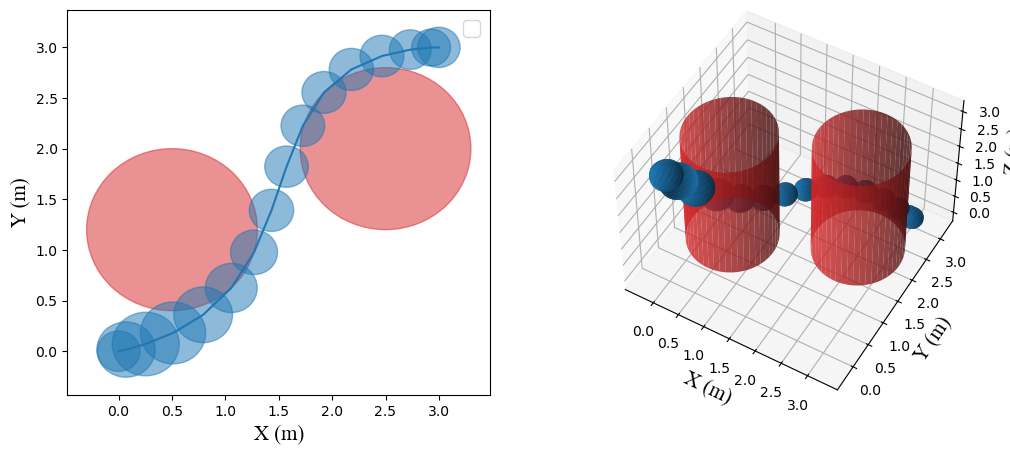

In [21]:
fig = plt.figure(1,figsize=(12,5))
ax = fig.add_subplot(121)
for ce,H in zip(c_list,H_list) :
        rx = 1/H[0,0]
        ry = 1/H[1,1]
        circle1 = Ellipse((ce[0],ce[1]),rx*2,ry*2,color='tab:red',alpha=0.5,fill=True)
        ax.add_patch(circle1)
for i in range(N+1) :
        plot_ellipse_2D(ax,Qnom[i],xnom[i])
ax.set_xlabel('X (m)',**csfont)
ax.set_ylabel('Y (m)',**csfont)
ax.plot(xnom[:,0],xnom[:,1],color='tab:blue')
plt.legend(fontsize=15)
plt.subplot

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(Xo1, Yo1, Zo1, alpha=0.8,color='tab:red')
ax.plot_surface(Xo2, Yo2, Zo2, alpha=0.8,color='tab:red')
ax.set_xlabel('X (m)',**csfont)
ax.set_ylabel('Y (m)',**csfont)
ax.set_zlabel('Z (m)',**csfont)
ax.plot(xnom[:, 0],xnom[:, 1], xnom[:, 2],'o-',color='tab:blue')
for i in range(N+1) :
        plot_ellipse_3D(ax,Qnom[i],xnom[i])
    
ax.view_init(50, -60)
# plt.gca().set_aspect('equal', adjustable='box')

In [22]:
x0_sample = []
num_sample = 50
for i in range(num_sample) :
    z = np.random.randn(ix)
    z = z / np.linalg.norm(z)
    x_s = xnom[0] + scipy.linalg.sqrtm(Qnom[0])@z
    x0_sample.append(x_s)


In [23]:
tsam,xsam,usam,wsam,xsamp = get_sample_trajectory(xi,x0_sample,xnom,unom,Qnom,Ynom,myModel,N,ix,iu,iw,delT,
                                            flag_noise=True)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


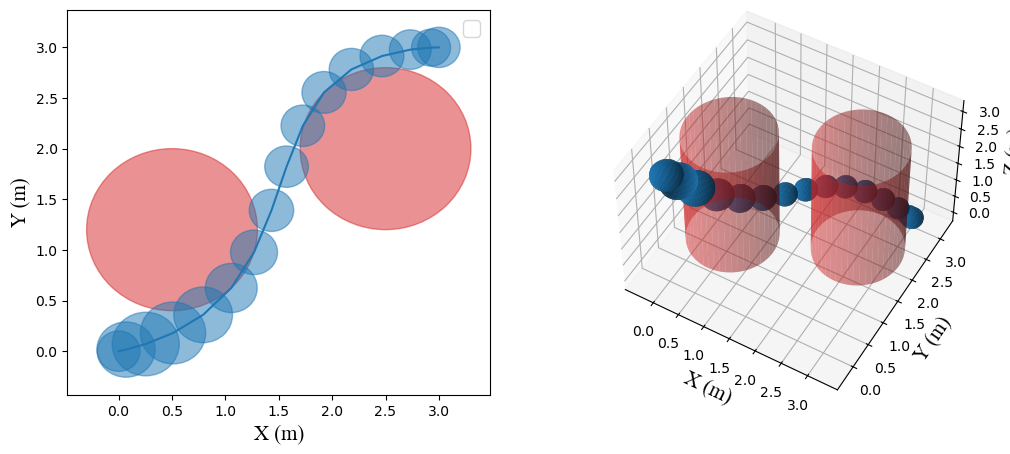

In [24]:
fig = plt.figure(1,figsize=(12,5))
ax = fig.add_subplot(121)
for ce,H in zip(c_list,H_list) :
        rx = 1/H[0,0]
        ry = 1/H[1,1]
        circle1 = Ellipse((ce[0],ce[1]),rx*2,ry*2,color='tab:red',alpha=0.5,fill=True)
        ax.add_patch(circle1)
for i in range(N+1) :
        plot_ellipse_2D(ax,Qnom[i],xnom[i])
# for xsam_e in xsamp :
#     ax.plot(xsam_e[:,0], xsam_e[:,1],'o-',markersize=3.0, linewidth=1.0,alpha=1.0,color='tab:purple')
ax.set_xlabel('X (m)',**csfont)
ax.set_ylabel('Y (m)',**csfont)
ax.plot(xnom[:,0],xnom[:,1],color='tab:blue')
plt.legend(fontsize=15)
plt.subplot

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(Xo1, Yo1, Zo1, alpha=0.5,color='tab:red')
ax.plot_surface(Xo2, Yo2, Zo2, alpha=0.5,color='tab:red')
ax.set_xlabel('X (m)',**csfont)
ax.set_ylabel('Y (m)',**csfont)
ax.set_zlabel('Z (m)',**csfont)
ax.plot(xnom[:, 0],xnom[:, 1], xnom[:, 2],'o-',color='tab:blue')
for i in range(N+1) :
        plot_ellipse_3D(ax,Qnom[i],xnom[i])
# for xsam_e in xsamp :
#     ax.plot(xsam_e[:,0],xsam_e[:,1],xsam_e[:,2],'o-',markersize=3.0, linewidth=1.0,alpha=1.0,color='tab:purple')
    
ax.view_init(50, -60)
# plt.gca().set_aspect('equal', adjustable='box')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


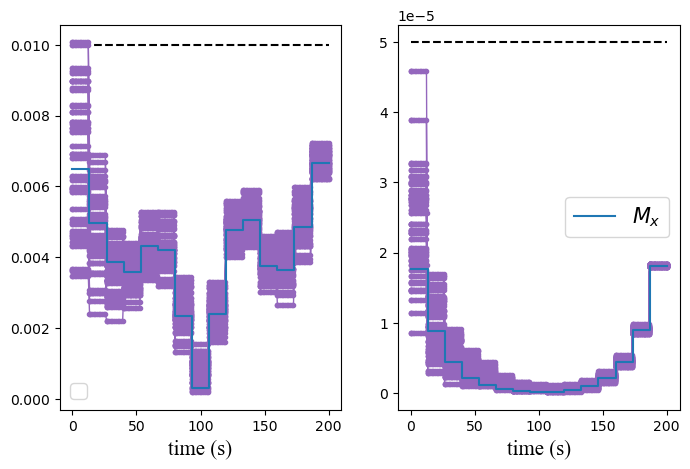

In [25]:
fig = plt.figure(3,figsize=(8,5))
ax = fig.add_subplot(121)
ax.set_xlabel('time (s)',**csfont)
ax.plot(tnom, tnom*0 + myConst.Tmax,'--',color='black')
for t_e,usam_e in zip(tsam,usam) :
    Tnorm = np.linalg.norm(usam_e[:,0:3],axis=1)
    Mnorm = np.linalg.norm(usam_e[:,3:],axis=1)
    ax.plot(t_e, Tnorm,'o-',markersize=3.0, linewidth=1.0,alpha=1.0,color='tab:purple')
ax.legend(prop=font)
Tnorm = np.linalg.norm(unom[:,0:3],axis=1)
ax.step(tnom, [*Tnorm[:N],Tnorm[N-1]],'-',
        color='tab:blue',where='post',label='$M_x$')
ax = fig.add_subplot(122)
ax.set_xlabel('time (s)',**csfont)
ax.plot(tnom, tnom*0 + myConst.Mmax,'--',color='black')
for t_e,usam_e in zip(tsam,usam) :
    Mnorm = np.linalg.norm(usam_e[:,3:],axis=1)
    ax.plot(t_e, Mnorm,'o-',markersize=3.0, linewidth=1.0,alpha=1.0,color='tab:purple')
Mnorm = np.linalg.norm(unom[:,3:],axis=1)
ax.step(tnom, [*Mnorm[:N],Mnorm[N-1]],'-',
        color='tab:blue',where='post',label='$M_x$')
ax.legend(prop=font)

## run

In [26]:
total_iter = 10
max_iter_trajopt = 1

tol_funl = 1e-8
tol_traj = 1e-8
tol_vc = 1e-8
tol_dyn = 1e-8

alpha = 0.99
lambda_mu = 0.1
funl_w_tr = 1e-8
w_Q = 1
w_K = 5*1e2

traj_solver= trajopt('freeflyer',N,tf,max_iter_trajopt,myModel,myCost,myConst,Scaling=traj_scaling,
              w_c=1,w_vc=1e2,w_tr=1e1,tol_vc=1e-6,tol_tr=1e-4,tol_dyn=1e-3,
              ignore_dpp=False,
              verbosity=False)

funl_solver = funlopt('freeflyer',ix,iu,iq,ip,iw,N,funl_scaling,
                      alpha=alpha,
                      lambda_mu=lambda_mu,
                      w_Q = w_Q,
                      w_K = w_K,
                      w_tr=funl_w_tr,
                      ignore_dpp=True,
                      solver="MOSEK",
                      flag_nonlinearity=True)
                      
# funl_solver.cvx_initialize(Qini,Qf,num_const_state=len(c_list)+2,num_const_input=2)
funl_solver.cvx_initialize(Qini,Qf,num_const_state=2,num_const_input=2)
lip_estimator = Lipschitz('freeflyer',ix,iu,iq,ip,iw,N,num_sample=256,
                            flag_uniform=True)

from jointsynthesis import jointsynthesis
JS = jointsynthesis(myModel,traj_solver,funl_solver,lip_estimator,total_iter,
                   tol_traj,tol_funl,tol_vc,tol_dyn,verbosity=True)

Is DPP?  True
nonlinear funnel
Is DPP?  True


In [27]:
history = JS.run(xi,xf,xnom,unom,Qnom,Ynom,Knom)

|iter| traj_cost | funl_cost |   vc   |   Delta_T   |   Delta_F   | e_prop  |gamma diff|
|    |           |           | log10  |   log10     |   log10     | log10   |          |
|1   |0.000      |328.427    |-1.95(0)|-0.317    (0)|-2.3      (0)|-1.949(0)|0.47120919|
|2   |0.001      |328.832    |-2.52(0)|-1.33     (0)|-2.78     (0)|-2.524(0)|0.11667913|
|3   |0.001      |329.015    |-3.13(0)|-1.73     (0)|-3.59     (0)|-3.125(0)|0.00604469|
|4   |0.001      |329.033    |-13.5(1)|-2.48     (0)|-5.76     (0)|-9.472(1)|0.00181454|
|5   |0.001      |329.033    |-11.5(1)|-7.31     (0)|-8.31     (1)|-9.461(1)|0.00149299|
|6   |0.001      |329.032    |-12.5(1)|-8.63     (1)|-8.46     (1)|-9.472(1)|0.00017502|
SUCCESS


In [28]:
import pypickle
name = "freeflyer_history"
filepath = '/Users/taewankim/Documents/Code/ForPapers/2022_IJRNC_joint_synthesis/data/'+name+'.pkl'
status = pypickle.save(filepath, history)

[pypickle] Pickle file saved: [/Users/taewankim/Documents/Code/ForPapers/2022_IJRNC_joint_synthesis/data/freeflyer_history.pkl]


In [29]:
# save initial guess
tmp = {}
tmp['x0'] = xnom
tmp['u0'] = unom
tmp['Q0'] = Qnom
tmp['K0'] = Knom
tmp['Y0'] = Ynom
name = "freeflyer_initial_guess"
filepath = '/Users/taewankim/Documents/Code/ForPapers/2022_IJRNC_joint_synthesis/data/'+name+'.pkl'
status = pypickle.save(filepath,tmp)

[pypickle] Pickle file saved: [/Users/taewankim/Documents/Code/ForPapers/2022_IJRNC_joint_synthesis/data/freeflyer_initial_guess.pkl]


# Computational time

In [30]:
time_derivs = []
time_trajopt = []
time_funlopt = []
time_lipschitz = []

for his in history[1:] :
    time_derivs.append(his['t_derivs'])
    time_trajopt.append(his['t_trajopt'])
    time_funlopt.append(his['t_funlopt'])
    time_lipschitz.append(his['t_Lipschitz'])
def mean_list(l) :
    return sum(l)/len(l)
mean_derivs = mean_list(time_derivs)
mean_trajopt = mean_list(time_trajopt)
mean_funlopt = mean_list(time_funlopt)
mean_lipschitz = mean_list(time_lipschitz)
print("mean_derivs",mean_derivs)
print("mean_trajopt",mean_trajopt)
print("mean_funlopt",mean_funlopt)
print("mean_lipschitz",mean_lipschitz)

mean_derivs 0.07282061576843261
mean_trajopt 0.02430691719055176
mean_funlopt 10.071954345703125
mean_lipschitz 2.697501611709595


# Evaluate the generated traj and funl

In [ ]:
from utils.utils_alg import forward_full_with_K,get_sample_trajectory
import scipy

In [ ]:
xbar = history[-1]['x']
ubar = history[-1]['u']
Qbar = history[-1]['Q']
Ybar = history[-1]['Y']
Kbar = history[-1]['K']
gammabar = history[-1]['gamma']

# Sample from initial set

In [ ]:
x0_sample = []
num_sample = 50
for i in range(num_sample) :
    z = np.random.randn(ix)
    z = z / np.linalg.norm(z)
    x_s = xbar[0] + scipy.linalg.sqrtm(Qbar[0])@z
    x0_sample.append(x_s)


In [ ]:
tsam,xsam,usam,wsam,xsamp = get_sample_trajectory(xi,x0_sample,xbar,ubar,Qbar,Ybar,myModel,N,ix,iu,iw,delT,
                                            flag_noise=True)


In [ ]:
fig = plt.figure(1,figsize=(12,5))
ax = fig.add_subplot(121)
for ce,H in zip(c_list,H_list) :
        rx = 1/H[0,0]
        ry = 1/H[1,1]
        circle1 = Ellipse((ce[0],ce[1]),rx*2,ry*2,color='tab:red',alpha=0.5,fill=True)
        ax.add_patch(circle1)
for i in range(N+1) :
        plot_ellipse_2D(ax,Qbar[i],xbar[i])
for xsam_e in xsamp :
    ax.plot(xsam_e[:,0], xsam_e[:,1],'o-',markersize=3.0, linewidth=1.0,alpha=1.0,color='tab:purple')
ax.set_xlabel('X (m)',**csfont)
ax.set_ylabel('Y (m)',**csfont)
ax.plot(xbar[:,0],xbar[:,1],color='tab:blue')
plt.legend(fontsize=15)
plt.subplot

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(Xo1, Yo1, Zo1, alpha=0.5,color='tab:red')
ax.plot_surface(Xo2, Yo2, Zo2, alpha=0.5,color='tab:red')
ax.set_xlabel('X (m)',**csfont)
ax.set_ylabel('Y (m)',**csfont)
ax.set_zlabel('Z (m)',**csfont)
ax.plot(xbar[:, 0],xbar[:, 1], xbar[:, 2],'o-',color='tab:blue')
for i in range(N+1) :
        plot_ellipse_3D(ax,Qbar[i],xbar[i])
# for xsam_e in xsamp :
#     ax.plot(xsam_e[:,0],xsam_e[:,1],xsam_e[:,2],'o-',markersize=3.0, linewidth=1.0,alpha=1.0,color='tab:purple')
    
ax.view_init(50, -60)
# plt.gca().set_aspect('equal', adjustable='box')

In [ ]:
fig = plt.figure(3,figsize=(8,5))
ax = fig.add_subplot(121)
ax.set_xlabel('time (s)',**csfont)
ax.plot(tnom, tnom*0 + myConst.Tmax,'--',color='black')
for t_e,usam_e in zip(tsam,usam) :
    Tnorm = np.linalg.norm(usam_e[:,0:3],axis=1)
    Mnorm = np.linalg.norm(usam_e[:,3:],axis=1)
    ax.plot(t_e, Tnorm,'-',markersize=3.0, linewidth=1.0,alpha=1.0,color='tab:purple')
ax.legend(prop=font)
Tnorm = np.linalg.norm(ubar[:,0:3],axis=1)
ax.step(tnom, [*Tnorm[:N],Tnorm[N-1]],'-',
        color='tab:blue',where='post',label='$M_x$')
ax = fig.add_subplot(122)
ax.set_xlabel('time (s)',**csfont)
ax.plot(tnom, tnom*0 + myConst.Mmax,'--',color='black')
for t_e,usam_e in zip(tsam,usam) :
    Mnorm = np.linalg.norm(usam_e[:,3:],axis=1)
    ax.plot(t_e, Mnorm,'-',markersize=3.0, linewidth=1.0,alpha=1.0,color='tab:purple')
Mnorm = np.linalg.norm(ubar[:,3:],axis=1)
ax.step(tnom, [*Mnorm[:N],Mnorm[N-1]],'-',
        color='tab:blue',where='post',label='$M_x$')
ax.legend(prop=font)

In [ ]:
fS = 15
plt.figure(0,figsize=(15,7))
plot_traj_set(xbar,ubar,c_list,H_list,Qbar,xi=xi,xf=xf,Qi=Qini,Qf=Qf,plt=plt)
plt.legend(fontsize=fS)
plt.rcParams["font.family"] = "Times New Roman"
plt.axis([-1.0, 9.0, -1.0, 5.0])
# plt.savefig('../images/first_iteration/proposed.pdf')

In [ ]:
fS = 20
plt.figure(0,figsize=(15,7))
plot_traj_set(xbar,ubar,c_list,H_list,Qbar,xi=xi,xf=xf,Qi=Qini,Qf=Qf,plt=plt,flag_label=True,fS=fS)
# for xsam_e in xsam :
for xsam_e in xsamp :
    plt.plot(xsam_e[:,0], xsam_e[:,1],'o-',markersize=3.0, linewidth=1.0,alpha=1.0,color='tab:purple')
plt.plot(1e3,1e3,'o-',color='tab:purple',label='samples')
# plt.plot(xnom[:,0],xnom[:,1],'-.',color='tab:brown',label='traj w/o funnel')
plt.legend(fontsize=fS)
plt.grid(True)
plt.rcParams["font.family"] = "Times New Roman"
plt.axis([-1.0, 9.0, -1.0, 5.0])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.savefig('../images/traj_result_new.pdf')

In [ ]:
fS = 20
plt.figure(0,figsize=(15,5))
alpha = 1.0
t_index = np.array(range(N+1))*delT
for i in range(num_sample) :
    tsam_e = tsam[i]
    xsam_e = xsam[i]
    usam_e = usam[i]
#     plot_state_input(tsam_e,xsam_e,usam_e,None,None,N,delT,alpha,plt,flag_step=False)

    plt.subplot(121)
    plt.plot(tsam_e, usam_e[:,0],color='tab:purple',alpha=alpha,linewidth=2.0)
    plt.subplot(122)
    plt.plot(tsam_e, usam_e[:,1],color='tab:purple',alpha=alpha,linewidth=2.0)
plt.subplot(121)
plt.plot(tsam_e, usam_e[:,0]*0+myConst.vmax,'-.',color='tab:red',alpha=1.0,linewidth=2.0,label='limit')
plt.plot(tsam_e, usam_e[:,0]*0+myConst.vmin,'-.',color='tab:red',alpha=1.0,linewidth=2.0)
plt.step(t_index, [*ubar[:N,0],ubar[N-1,0]],'--',color='tab:orange',alpha=1.0,where='post',linewidth=2.0,label='nominal')
plt.plot(1e3, 1e3,'-',color='tab:purple',alpha=1.0,linewidth=1.0,label='samples')
plt.xlabel('time (s)', fontsize = fS)
plt.ylabel('$u_v$ (m/s)', fontsize = fS)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.axis([0.0, tf, -0.5, 3.5])
plt.grid(True)
plt.subplot(122)
plt.plot(tsam_e, usam_e[:,1]*0+myConst.wmax,'-.',color='tab:red',alpha=1.0,linewidth=2.0)
plt.plot(tsam_e, usam_e[:,1]*0+myConst.wmin,'-.',color='tab:red',alpha=1.0,linewidth=2.0,label='limit')
plt.step(t_index, [*ubar[:N,1],ubar[N-1,1]],'--',color='tab:orange',alpha=1.0,where='post',linewidth=2.0,label='nominal')
plt.plot(1e3, 1e3,'-',color='tab:purple',alpha=1.0,linewidth=1.0,label='samples')
plt.xlabel('time (s)', fontsize = fS)
plt.ylabel('$u_{\Theta}$ (rad/s)', fontsize = fS)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.axis([0.0, tf, -3, 3])
plt.legend(fontsize=fS)
plt.rcParams["font.family"] = "Times New Roman"
plt.grid(True)
# plt.savefig('../images/input_result_new.pdf')


In [ ]:
# fS = 20
# plt.figure(0,figsize=(10,5))
# alpha = 0.5
# t_index = np.array(range(N+1))*delT
# for i in range(num_sample) :
#     tsam_e = tsam[i]
#     xsam_e = xsam[i]
#     wsam_e = wsam[i]
# #     plot_state_input(tsam_e,xsam_e,usam_e,None,None,N,delT,alpha,plt,flag_step=False)
#     plt.subplot(121)
#     plt.plot(tsam_e, wsam_e[:,0],color='tab:purple',alpha=alpha,linewidth=1.0)
#     plt.subplot(122)
#     plt.plot(tsam_e, wsam_e[:,1],color='tab:purple',alpha=alpha,linewidth=1.0)
# plt.subplot(121)
# plt.plot(1e3, 1e3,'-',color='tab:purple',alpha=1.0,linewidth=1.0,label='samples')
# plt.xlabel('time (s)', fontsize = fS)
# plt.ylabel('w1 (m)', fontsize = fS)
# plt.axis([0.0, tf, -2, 2])
# plt.subplot(122)
# plt.plot(1e3, 1e3,'-',color='tab:purple',alpha=1.0,linewidth=1.0,label='samples')
# plt.xlabel('time (s)', fontsize = fS)
# plt.ylabel('w2 (m)', fontsize = fS)
# plt.axis([0.0, tf, -2, 2])
# plt.legend(fontsize=fS)
# plt.rcParams["font.family"] = "Times New Roman"
# # plt.savefig('../images/disturbance.pdf')

In [ ]:
fS = 15
plt.figure(0,figsize=(4,4))
plot_traj_set(xbar,ubar,c_list,H_list,Qbar,xi=xi,xf=xf,Qi=Qini,Qf=Qf,plt=plt,flag_label=False)
for xsam_e in xsamp :
    plt.plot(xsam_e[:,0], xsam_e[:,1],'o',markersize=1.0, linewidth=1.0,alpha=1.0,color='tab:purple')
plt.plot(1e3,1e3,'o-',color='tab:purple',label='samples')
# plt.plot(xnom[:,0],xnom[:,1],'-.',color='tab:brown',label='traj w/o funnel')
# plt.legend(fontsize=fS)
plt.grid(True)
plt.rcParams["font.family"] = "Times New Roman"
plt.axis([3.7, 5.7, 1.5, 3.5])
plt.axis('off')
# plt.savefig('../images/traj_result_new_expansion.pdf')

In [ ]:
fS = 15
plt.figure(0,figsize=(15,7))
plot_traj_set(xbar,ubar,c_list,H_list,Qbar,xi=xi,xf=xf,Qi=Qini,Qf=Qf,plt=plt,flag_label=True)
for xsam_e in xsamp :
    plt.plot(xsam_e[:,0], xsam_e[:,1],'o',markersize=3.0, linewidth=1.0,alpha=1.0,color='tab:purple')
#     plt.plot(xsam_e[1,0], xsam_e[1,1],'o',markersize=3.0, linewidth=1.0,alpha=1.0,color='tab:purple')
plt.plot(1e3,1e3,'o-',color='tab:purple',label='samples')
# plt.plot(xnom[:,0],xnom[:,1],'-.',color='tab:brown',label='traj w/o funnel')
# plt.legend(fontsize=fS)
plt.grid(True)
plt.rcParams["font.family"] = "Times New Roman"
plt.axis([-1, 1, -1, 1])
# plt.savefig('../images/traj_result.pdf')

In [ ]:
fS = 15
plt.figure(0,figsize=(15,7))
plot_traj_set(xbar,ubar,c_list,H_list,Qbar,xi=xi,xf=xf,Qi=Qini,Qf=Qf,plt=plt,flag_label=True)
for xsam_e in xsamp :
    plt.plot(xsam_e[:,0], xsam_e[:,1],'o',markersize=3.0, linewidth=1.0,alpha=1.0,color='tab:purple')
#     plt.plot(xsam_e[1,0], xsam_e[1,1],'o',markersize=3.0, linewidth=1.0,alpha=1.0,color='tab:purple')
plt.plot(1e3,1e3,'o-',color='tab:purple',label='samples')
# plt.plot(xnom[:,0],xnom[:,1],'-.',color='tab:brown',label='traj w/o funnel')
# plt.legend(fontsize=fS)
plt.grid(True)
plt.rcParams["font.family"] = "Times New Roman"
plt.axis([7, 9, 3, 5])
# plt.savefig('../images/traj_result.pdf')

# Search the case of violating the invariance

In [ ]:
from scipy.integrate import solve_ivp
def dfdt(t,x,u,w) :
    return np.squeeze(myModel.forward_uncertain(x,u,w))

num_test = 10000
for i in range(num_test) :
    z = np.random.randn(ix)
    z = z / np.linalg.norm(z)
    x_s = xbar[0] + scipy.linalg.sqrtm(Qbar[0])@z
    
    u = ubar[0] + Kbar[0]@(x_s-xbar[0])
    
    z = np.random.randn(iw)
    w = z / np.linalg.norm(z)
#     w = np.array([1,0])
    
    sol = solve_ivp(dfdt,(0,delT),x_s,args=(u,w),max_step=delT/10,method='RK45',rtol=1e-6,atol=1e-10)
    
    xnew = sol.y[:,-1]
    radi_next = (xnew-xbar[1]).T@np.linalg.inv(Qbar[1])@(xnew-xbar[1])
    if radi_next > 1 :
        print("found!",radi_next)
        break
    if i == num_test - 1 :
        print("no case")
        
    
    

In [ ]:
fS = 15
plt.figure(0,figsize=(15,7))
plot_traj_set(xbar[0:2],ubar[0:2],c_list,H_list,Qbar[0:2],xi=xi,xf=xf,Qi=Qini,Qf=Qf,plt=plt,flag_label=True)
plt.plot(xnew[0], xnew[1],'o',markersize=3.0, linewidth=1.0,alpha=1.0,color='tab:purple')
plt.plot(1e3,1e3,'o-',color='tab:purple',label='samples')
plt.grid(True)
plt.rcParams["font.family"] = "Times New Roman"
plt.axis([-1, 1, -1, 1])